# Structured & Time Series Data

This notebook walks through an implementation of a deep learning model for structured time series data using Keras.  We’ll use the dataset from Kaggle’s [Rossmann Store Sales competition](https://www.kaggle.com/c/rossmann-store-sales).  The steps outlined below are inspired by (and partially based on) lesson 3 of Jeremy Howard’s [fast.ai course](http://course.fast.ai) where he builds a model for the Rossman dataset using PyTorch and the fast.ai library.

The focus here is on implementing a deep learning model for structured data.  I’ve skipped a bunch of pre-processing steps that are specific to this particular dataset but don’t reflect general principles about applying deep learning to tabular datasets.  If you’re interested, you’ll find complete step-by-step instructions on creating the “joined” dataset in [this notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson3-rossman.ipynb).  With that, let’s get started!

First we need to get a few imports out of the way.  All of these should come standard with an Anaconda install.  I’m also specifying the path where I’ve pre-saved the “joined” dataset that we’ll use as a starting point (created from running the first few sections of the above-referenced notebook).

(As an aside, I’m using [Paperspace](https://www.paperspace.com) to run this notebook.  If you’re not familiar with it, Paperspace is a cloud service that lets you rent GPU instances much cheaper than AWS.  It’s a great way to get started if you don’t have your own hardware.)


In [2]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

PATH = '/home/paperspace/data/rossmann/'

Read the data file into a pandas dataframe and take a peek at the data to see what we’re working with.

In [3]:
data = pd.read_feather(f'{PATH}joined')
data.shape

(844338, 93)

In [4]:
data.head().T.head(93)

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


The data consists of ~800,000 records with a variety of features used to predict sales at a given store on a given day.  As mentioned before, we’re skipping over details about where these features came from as it’s not the focus of this notebook, but you can find more info through the links above.  Next we’ll define variables that group our features into continuous and categorical buckets.  This is very important as neural networks (really anything other than tree models) do not natively handle categorical data well.

In [5]:
target = 'Sales'
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']
cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

Set some reasonable default values for missing information so our pre-processing steps won’t fail.

In [6]:
data = data.set_index('Date')
data[cat_vars] = data[cat_vars].fillna(value='')
data[cont_vars] = data[cont_vars].fillna(value=0)

Now we can do something with the categorical variables.  The simplest first step is to use scikit-learn’s LabelEncoder class to transform the raw category values (many of which are plain text) into unique integers, where each integer maps to a distinct value in that category.  The code block below saves the fitted encoders (we’ll need them later) and prints out the unique labels that each encoder found.

In [7]:
encoders = {}
for v in cat_vars:
    le = LabelEncoder()
    le.fit(data[v].values)
    encoders[v] = le
    data.loc[:, v] = le.transform(data[v].values)
    print('{0}: {1}'.format(v, le.classes_))

Store: [   1    2    3 ... 1113 1114 1115]
DayOfWeek: [1 2 3 4 5 6 7]
Year: [2013 2014 2015]
Month: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Day: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
StateHoliday: [False  True]
CompetitionMonthsOpen: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Promo2Weeks: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
StoreType: ['a' 'b' 'c' 'd']
Assortment: ['a' 'b' 'c']
PromoInterval: ['' 'Feb,May,Aug,Nov' 'Jan,Apr,Jul,Oct' 'Mar,Jun,Sept,Dec']
CompetitionOpenSinceYear: [1900 1961 1990 1994 1995 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015]
Promo2SinceYear: [1900 2009 2010 2011 2012 2013 2014 2015]
State: ['BE' 'BW' 'BY' 'HB,NI' 'HE' 'HH' 'NW' 'RP' 'SH' 'SN' 'ST' 'TH']
Week: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42

Split the data set into training and validation sets.  To preserve the temporal nature of the data and make sure that we don’t have any information leaks, we’ll just take everything past a certain date and use that as our validation set.

In [8]:
train = data[data.index < datetime.datetime(2015, 7, 1)]
val = data[data.index >= datetime.datetime(2015, 7, 1)]

X = train[cat_vars + cont_vars].copy()
X_val = val[cat_vars + cont_vars].copy()
y = train[target].copy()
y_val = val[target].copy()

Next we can apply scaling to our continuous variables.  We can once again leverage scikit-learn and use the StandardScaler class for this.  The proper way to apply scaling is to “fit” the scaler on the training data and then apply the same transformation to both the training and validation data (this is why we had to split the data set in the last step).

In [9]:
scaler = StandardScaler()
X.loc[:, cont_vars] = scaler.fit_transform(X[cont_vars].values)
X_val.loc[:, cont_vars] = scaler.transform(X_val[cont_vars].values)

Normalize the data types that each variable is stored as.  This is not strictly necessary but helps save storage space (and potentially processing time, although I’m not sure about that one).

In [10]:
for v in cat_vars:
    X[v] = X[v].astype('int').astype('category').cat.as_ordered()
    X_val[v] = X_val[v].astype('int').astype('category').cat.as_ordered()
for v in cont_vars:
    X[v] = X[v].astype('float32')
    X_val[v] = X_val[v].astype('float32')

Let’s take a look at where we’re at.  The data should basically be ready to move into the modeling phase.

In [11]:
X.shape, X_val.shape, y.shape, y_val.shape

((814150, 38), (30188, 38), (814150,), (30188,))

In [12]:
X.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-30,0,1,2,5,29,0,24,0,2,0,...,-1.964009,0.047353,-0.310342,-2.314223,1.008659,0.885609,-0.381079,1.159128,1.116479,-0.476624
2015-06-30,1,1,2,5,29,0,24,25,0,0,...,-1.147185,-1.065656,-0.646876,-0.502029,1.008659,0.885609,-0.063489,1.159128,1.116479,-0.476624
2015-06-30,2,1,2,5,29,0,24,25,0,0,...,-1.453494,-0.397851,-1.151678,-1.861175,1.544990,0.885609,-0.381079,1.159128,1.116479,2.098092
2015-06-30,3,1,2,5,29,0,24,0,2,2,...,-1.453494,-0.175249,-0.310342,-0.502029,0.025384,0.885609,-0.063489,1.159128,1.116479,-0.476624
2015-06-30,4,1,2,5,29,0,2,0,0,0,...,-1.096133,-0.954355,-0.310342,-0.048980,-0.421559,0.885609,-0.381079,1.159128,1.116479,-0.476624


In [13]:
X.dtypes

Store                       category
DayOfWeek                   category
Year                        category
Month                       category
Day                         category
StateHoliday                category
CompetitionMonthsOpen       category
Promo2Weeks                 category
StoreType                   category
Assortment                  category
PromoInterval               category
CompetitionOpenSinceYear    category
Promo2SinceYear             category
State                       category
Week                        category
Events                      category
Promo_fw                    category
Promo_bw                    category
StateHoliday_fw             category
StateHoliday_bw             category
SchoolHoliday_fw            category
SchoolHoliday_bw            category
CompetitionDistance          float32
Max_TemperatureC             float32
Mean_TemperatureC            float32
Min_TemperatureC             float32
Max_Humidity                 float32
M

We now basically have two options when it comes to handling of categorical variables.  The first option, which is the “traditional” way of handling categories, is to do a one-hot encoding for each category.  This approach would create a binary variable for each unique value in each category, with the value being a 1 for the “correct” category and 0 for everything else.  One-hot encoding works fairly well and is quite easy to do (there’s even a scikit-learn class for it), however it’s not perfect.  It’s particularly challenging with high-cardinality variables because it creates a very large, very sparse array that’s hard to learn from.

Fortunately there’s a better way, which is something called entity embeddings or category embeddings (I don’t think there’s a standard name for this yet).  Jeremy covers it extensively in the class (also [this blog post](https://towardsdatascience.com/deep-learning-structured-data-8d6a278f3088) explains it very well).  The basic idea is to create a distributed representation of the category using a vector of continuous numbers, where the length of the vector is lower than the cardinality of the category.  The key insight is that this vector is learned by the network.  It’s part of the optimization graph.  This allows the network to model complex, non-linear interactions between categories and other features in your input.  It’s quite useful, and as we’ll see at the end, these embeddings can be used in interesting ways outside of the neural network itself.

In order to build a model using embeddings, we need to do some more prep work on our categories.  First, let’s create a list of category names along with their cardinality.


In [14]:
cat_sizes = [(c, len(X[c].cat.categories)) for c in cat_vars]
cat_sizes

[('Store', 1115),
 ('DayOfWeek', 7),
 ('Year', 3),
 ('Month', 12),
 ('Day', 31),
 ('StateHoliday', 2),
 ('CompetitionMonthsOpen', 25),
 ('Promo2Weeks', 26),
 ('StoreType', 4),
 ('Assortment', 3),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 23),
 ('Promo2SinceYear', 8),
 ('State', 12),
 ('Week', 52),
 ('Events', 22),
 ('Promo_fw', 6),
 ('Promo_bw', 6),
 ('StateHoliday_fw', 3),
 ('StateHoliday_bw', 3),
 ('SchoolHoliday_fw', 8),
 ('SchoolHoliday_bw', 8)]

Now we need to decide on the length of each embedding vector.  Jeremy proposed using a simple formula: cardinality / 2, with a max of 50.

In [15]:
embedding_sizes = [(c, min(50, (c + 1) // 2)) for _, c in cat_sizes]
embedding_sizes

[(1115, 50),
 (7, 4),
 (3, 2),
 (12, 6),
 (31, 16),
 (2, 1),
 (25, 13),
 (26, 13),
 (4, 2),
 (3, 2),
 (4, 2),
 (23, 12),
 (8, 4),
 (12, 6),
 (52, 26),
 (22, 11),
 (6, 3),
 (6, 3),
 (3, 2),
 (3, 2),
 (8, 4),
 (8, 4)]

One last pre-processing step.  Keras requires that each “input” into the model be fed in as a separate array, and since each embedding has its own input, we need to do some transformations to get the data in the right format.

In [16]:
X_array = []
X_val_array = []

for i, v in enumerate(cat_vars):
    X_array.append(X.iloc[:, i])
    X_val_array.append(X_val.iloc[:, i])

X_array.append(X.iloc[:, len(cat_vars):])
X_val_array.append(X_val.iloc[:, len(cat_vars):])

len(X_array), len(X_val_array)

(23, 23)

Okay!  We’re finally ready to get to the modeling part.  Let’s get some imports out of the way.  I’ve also defined a custom metric to calculate root mean squared percentage error, which was originally used by the Kaggle competition to score this data set.

In [18]:
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation, BatchNormalization, Concatenate
from keras.layers import Dropout, Dense, Input, Reshape
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

def rmspe(y_true, y_pred):
    pct_var = (y_true - y_pred) / y_true
    return K.sqrt(K.mean(K.square(pct_var)))

Now for the model itself.  I tried to make this a similar to Jeremy’s model as I could, although there are some slight differences.  The “for” section at the top shows how to add embeddings.  They then get concatenated together and we apply dropout to the unified embedding layer.  Next we concatenate the output of that layer with our continuous inputs and feed the whole thing into a dense layer.  From here on it’s pretty standard stuff.  The only notable design choice is I omitted batch normalization because it seemed to hurt performance no matter what I did.  I also increased dropout a bit from what Jeremy had in his PyTorch architecture for this data.  Finally, note the inclusion of the “rmspe” function as a metric during the compile step (this will show up later during training).

In [19]:
def EmbeddingNet(cat_vars, cont_vars, embedding_sizes):
    inputs = []
    embed_layers = []
    for (c, (in_size, out_size)) in zip(cat_vars, embedding_sizes):
        i = Input(shape=(1,))
        o = Embedding(in_size, out_size, name=c)(i)
        o = Reshape(target_shape=(out_size,))(o)
        inputs.append(i)
        embed_layers.append(o)

    embed = Concatenate()(embed_layers)
    embed = Dropout(0.04)(embed)

    cont_input = Input(shape=(len(cont_vars),))
    inputs.append(cont_input)

    x = Concatenate()([embed, cont_input])

    x = Dense(1000, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    x = Dense(500, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('linear')(x)

    model = Model(inputs=inputs, outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=[rmspe])

    return model

One of the cool tricks Jeremy introduced in the class was the concept of a learning rate finder.  The idea is to start with a very small learning rate and slowly increase it throughout the epoch, and monitor the loss along the way.  It should end up as a curve that gives a good indication of where to set the learning rate for training.  To accomplish this with Keras, I found a script on Github that implements learning rate cycling and includes a class that’s supposed to mimic Jeremy’s LR finder.  We can just download a copy to the local directory.

In [22]:
!wget "https://raw.githubusercontent.com/titu1994/keras-one-cycle/master/clr.py"

--2018-10-04 20:20:17--  https://raw.githubusercontent.com/titu1994/keras-one-cycle/master/clr.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22310 (22K) [text/plain]
Saving to: ‘clr.py’

clr.py              100%[===================>]  21.79K  --.-KB/s    in 0.009s  

2018-10-04 20:20:17 (2.35 MB/s) - ‘clr.py’ saved [22310/22310]



Let’s set up and train the model for one epoch using the LRFinder class as a callback.  It will slowly but exponentially increase the learning rate each batch and track the loss so we can plot the results.

In [30]:
from clr import LRFinder

lr_finder = LRFinder(num_samples=X.shape[0], batch_size=128, minimum_lr=1e-5, maximum_lr=10,
                     lr_scale='exp', loss_smoothing_beta=0.995, verbose=False)
model = EmbeddingNet(cat_vars, cont_vars, embedding_sizes)
history = model.fit(x=X_array, y=y, batch_size=128, epochs=1, verbose=1, callbacks=[lr_finder],
                    validation_data=(X_val_array, y_val), shuffle=False)

Train on 814150 samples, validate on 30188 samples
Epoch 1/1
814150/814150 [==============================] - 73s 90us/step - loss: 2521.7429 - rmspe: 0.4402 - val_loss: 3441.1762 - val_rmspe: 0.5088


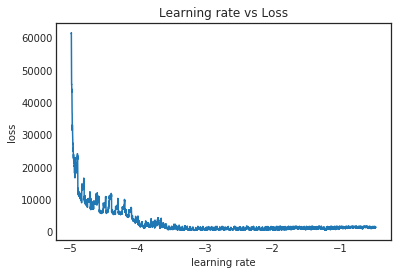

In [32]:
lr_finder.plot_schedule(clip_beginning=20)

It doesn’t look as good as the plot Jeremy used in the class.  The PyTorch version seemed to make it much more apparent where the loss started to level off.  I haven’t dug into this too closely but I’m guessing there are some "tricks" in that version that we aren't using.  If I had to eyeball this I’d say it’s recommending 1e-4 for the learning rate, but Jeremy used 1e-3 so we’ll go with that instead.

We’re now ready to train the model.  I’ve included two new callbacks (both built into Keras) to demonstrate how they work.  The first one automatically reduces the learning rate as we progress through training if the validation error stops improving.  The second one will save a copy of the model weights to a file every time we reach a new low in validation error.

In [38]:
model = EmbeddingNet(cat_vars, cont_vars, embedding_sizes)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='auto',
                               min_delta=10, cooldown=0, min_lr=0.0001)
checkpoint = ModelCheckpoint('best_model_weights.hdf5', monitor='val_loss', save_best_only=True)
history = model.fit(x=X_array, y=y, batch_size=128, epochs=20, verbose=1, callbacks=[lr_reducer, checkpoint],
                    validation_data=(X_val_array, y_val), shuffle=False)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


Train on 814150 samples, validate on 30188 samples
Epoch 1/20
814150/814150 [==============================] - 68s 83us/step - loss: 1138.6056 - rmspe: 0.2421 - val_loss: 1923.3162 - val_rmspe: 0.3177
Epoch 2/20
814150/814150 [==============================] - 66s 81us/step - loss: 962.1155 - rmspe: 0.2140 - val_loss: 1895.0041 - val_rmspe: 0.3015
Epoch 3/20
814150/814150 [==============================] - 66s 80us/step - loss: 850.5718 - rmspe: 0.1899 - val_loss: 1551.5644 - val_rmspe: 0.2554
Epoch 4/20
814150/814150 [==============================] - 66s 81us/step - loss: 760.7246 - rmspe: 0.1607 - val_loss: 1589.6841 - val_rmspe: 0.2556
Epoch 5/20
814150/814150 [==============================] - 66s 81us/step - loss: 723.1884 - rmspe: 0.1522 - val_loss: 2032.6661 - val_rmspe: 0.3093
Epoch 6/20
814150/814150 [==============================] - 66s 81us/step - loss: 701.6135 - rmspe: 0.1470 - val_loss: 1559.3813 - val_rmspe: 0.2455

Epoch 00006: ReduceLROnPlateau reducing learning rate

By the end it’s doing pretty good, and it looks like the model is still improving.  We can quickly get a snapshot of its performance using the “history” object that Keras’s "fit" method returns.

In [39]:
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
min_val_epoch = val_loss_history.index(min(val_loss_history)) + 1

print('min training loss = {0}'.format(min(loss_history)))
print('min val loss = {0}'.format(min(val_loss_history)))
print('min val epoch = {0}'.format(min_val_epoch))

min training loss = 542.9558401937004
min val loss = 698.6142525395542
min val epoch = 20


I also like to make plots to visually see what’s going on.  Let’s create a function that plots the training and validation loss history.

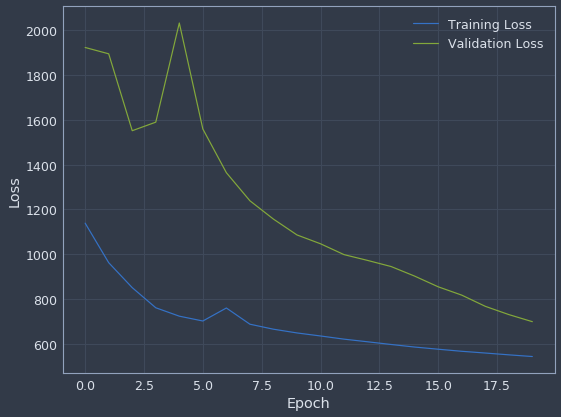

In [41]:
from jupyterthemes import jtplot
jtplot.style()

def plot_loss_history(history, n_epochs):
    fig, ax = plt.subplots(figsize=(8, 8 * 3 / 4))
    ax.plot(list(range(n_epochs)), history.history['loss'], label='Training Loss')
    ax.plot(list(range(n_epochs)), history.history['val_loss'], label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')
    fig.tight_layout()

plot_loss_history(history, 20)

The validation loss was pretty unstable early on but was really starting to converge toward the end of training.  We can do something similar for the learning rate history.

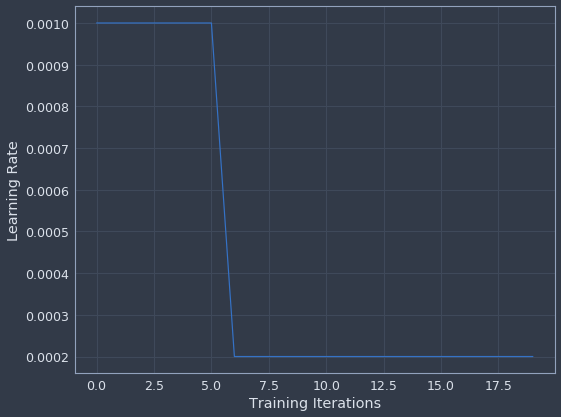

In [42]:
def plot_learning_rate(history):
    fig, ax = plt.subplots(figsize=(8, 8 * 3 / 4))
    ax.set_xlabel('Training Iterations')
    ax.set_ylabel('Learning Rate')
    ax.plot(history.history['lr'])
    fig.tight_layout()

plot_learning_rate(history)

One other innovation Jeremy introduced in the class is the idea of using learning rate cycles to help prevent the model from settling in a bad local minimum.  This is based on research by Leslie Smith that showed using this type of learning rate policy can lead to quicker convergence and better accuracy (this is also where the learning rate finder idea came from).  Fortunately the file we downloaded earlier includes support for cyclical learning rates in Keras, so we can try this out ourselves.  The policy Jeremy is currently recommending is called a “one-cycle” policy so that’s what we’ll try.

(As an aside, Jeremy [wrote a blog post](http://www.fast.ai/2018/04/30/dawnbench-fastai/) about this if you'd like to dig into its origins a bit more.  His results applying it to ImageNet were quite impressive.)

In [43]:
from clr import OneCycleLR

model2 = EmbeddingNet(cat_vars, cont_vars, embedding_sizes)
batch_size = 128
n_epochs = 10
lr_manager = OneCycleLR(num_samples=X.shape[0] + batch_size, num_epochs=n_epochs, batch_size=batch_size, max_lr=0.01,
                        end_percentage=0.1, scale_percentage=None, maximum_momentum=None,
                        minimum_momentum=None, verbose=False)
history = model2.fit(x=X_array, y=y, batch_size=batch_size, epochs=n_epochs, verbose=1,
                    callbacks=[checkpoint, lr_manager], validation_data=(X_val_array, y_val), shuffle=False)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Train on 814150 samples, validate on 30188 samples
Epoch 1/10
814150/814150 [==============================] - 76s 93us/step - loss: 1115.8234 - rmspe: 0.2384 - val_loss: 1625.4826 - val_rmspe: 0.2847
Epoch 2/10
814150/814150 [==============================] - 74s 90us/step - loss: 853.5083 - rmspe: 0.1828 - val_loss: 1308.4618 - val_rmspe: 0.2416
Epoch 3/10
814150/814150 [==============================] - 73s 90us/step - loss: 800.1833 - rmspe: 0.1622 - val_loss: 1379.4527 - val_rmspe: 0.2425
Epoch 4/10
814150/814150 [==============================] - 74s 91us/step - loss: 820.6853 - rmspe: 0.1627 - val_loss: 1353.2198 - val_rmspe: 0.2386
Epoch 5/10
814150/814150 [==============================] - 73s 90us/step - loss: 823.7708 - rmspe: 0.1641 - val_loss: 1423.9368 - val_rmspe: 0.2440
Epoch 6/10
814150/814150 [==============================] - 74s 90us/step - loss: 778.9107 - rmspe: 0.1548 - val_loss: 1425.7734 - val_rmspe: 0.2449
Epoch 7/10
814150/814150 [============================

As you can probably tell from the model error, I didn’t have a lot of success with this strategy.  I tried a few different configurations and nothing really worked, but I wouldn’t say it’s an indictment of the technique so much as it just didn’t happen to do well within the narrow scope that I attempted to apply it.  Nevertheless, I’m definitely adding it to my toolbox for future reference.

If my earlier description wasn’t clear, this is how the learning is supposed to evolve over time.  It forms a triangle from the starting point, coming back to the original learning rate towards the end and then decaying further as training wraps up.

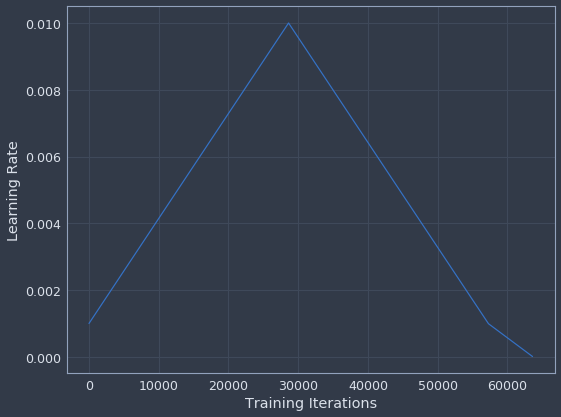

In [45]:
plot_learning_rate(lr_manager)

One last trick worth discussing is what we can do with the embeddings that our network learned.  Similar to word embeddings, these vectors contain potentially interesting information about how the values in each category relate to each other.  One really simple way to see this visually is to do a PCA transform on the learned embedding weights and plot the first two dimensions.  Let’s create a function to do just that.

In [46]:
def plot_embedding(model, encoders, category):
    embedding_layer = model.get_layer(category)
    weights = embedding_layer.get_weights()[0]
    pca = PCA(n_components=2)
    weights = pca.fit_transform(weights)
    weights_t = weights.T
    fig, ax = plt.subplots(figsize=(8, 8 * 3 / 4))
    ax.scatter(weights_t[0], weights_t[1])
    for i, day in enumerate(encoders[category].classes_):
        ax.annotate(day, (weights_t[0, i], weights_t[1, i]))
        fig.tight_layout()

We can now plot any categorical variable in the model and get a sense of which categories are more or less similar to each other.  For instance, if we examine "day of week", it seems to have picked up that Sunday (7 on the chart) is quite different than every other day for store sales.  And if we look at "state" (this data is for a German company BTW) there’s probably some regional similarity to the cluster in the bottom left.  It’s a really cool technique that potentially has a wide range of uses.

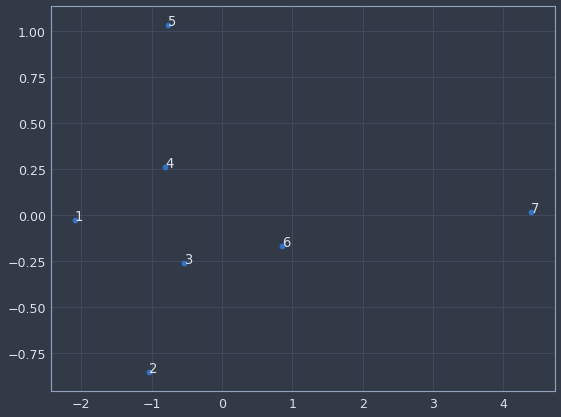

In [47]:
plot_embedding(model, encoders, 'DayOfWeek')

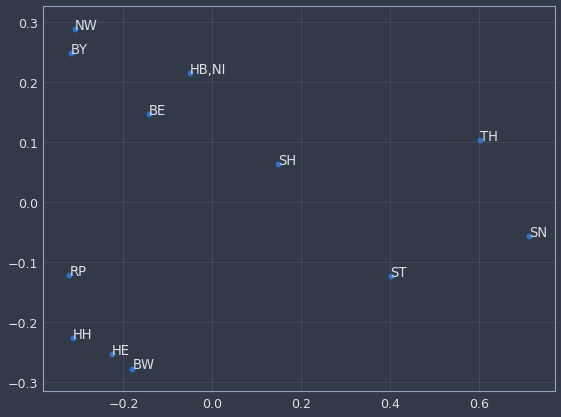

In [48]:
plot_embedding(model, encoders, 'State')